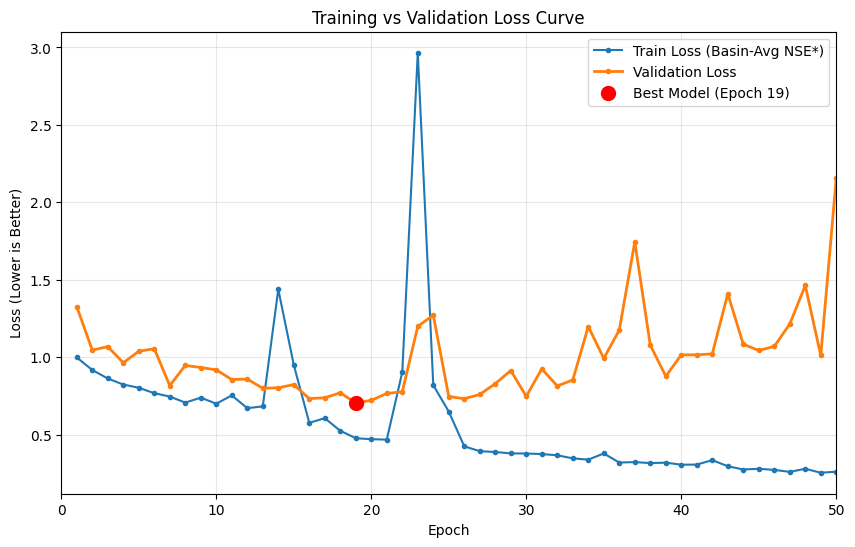

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from src.config import OUTPUT_DATA_DIR, PROCESSED_DATA_DIR

# --- 1. Parse the Log File ---
log_path = OUTPUT_DATA_DIR / "training_log.txt"

data = []
# Regex to find: "Epoch X/Y", "Train Loss ... : <val>", "Val Loss: <val>"
pattern = re.compile(r"Epoch (\d+)/\d+ \| Train Loss \(NSE\*\): ([\d\.]+) \| Val Loss: ([\d\.]+)")

with open(log_path, "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            data.append({
                "epoch": int(match.group(1)),
                "train_loss": float(match.group(2)),
                "val_loss": float(match.group(3))
            })

df_logs = pd.DataFrame(data)

# --- 2. Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(df_logs["epoch"], df_logs["train_loss"], label="Train Loss (Basin-Avg NSE*)", marker='.')
plt.plot(df_logs["epoch"], df_logs["val_loss"], label="Validation Loss", marker='.', linewidth=2)

# Highlight the Minimum Validation Point (Best Model)
best_epoch = df_logs.loc[df_logs["val_loss"].idxmin()]
plt.scatter(best_epoch["epoch"], best_epoch["val_loss"], color='red', s=100, zorder=5, label=f"Best Model (Epoch {int(best_epoch['epoch'])})")

plt.xlabel("Epoch")
plt.ylabel("Loss (Lower is Better)")
plt.title("Training vs Validation Loss Curve")
plt.grid(True, alpha=0.3)
plt.xlim(0,50)
plt.legend()

plt.show()

In [8]:
import pandas as pd
import numpy as np
from src.config import OUTPUT_DATA_DIR, PROCESSED_DATA_DIR

# --- Helper Functions ---
def calculate_nse(obs, sim):
    """Computes Nash-Sutcliffe Efficiency. Returns NaN if not enough data."""
    mask = np.isfinite(obs) & np.isfinite(sim)
    obs_f = obs[mask]
    sim_f = sim[mask]
    
    if len(obs_f) < 10: return np.nan
        
    numerator = np.sum((obs_f - sim_f)**2)
    denominator = np.sum((obs_f - np.mean(obs_f))**2)
    
    return 1 - (numerator / denominator) if denominator != 0 else np.nan

print("⏳ Loading Data...")
# 1. Load Data
df_pred = pd.read_csv(OUTPUT_DATA_DIR / "test_set_predictions.csv", index_col=0, parse_dates=True)
df_flow_m3s = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)

# 2. Align Data
common_stations = df_pred.columns.intersection(df_flow_m3s.columns).intersection(df_static.index)
df_pred = df_pred[common_stations]
df_flow_m3s = df_flow_m3s.loc[df_pred.index, common_stations]

# 3. CONVERT OBSERVATIONS: m^3/s -> mm/day
# Formula: (Flow * 86.4) / Area_km2
print("   Converting observations from m3/s to mm/d...")
areas = df_static.loc[common_stations, 'basin_area_km2'].values
# Broadcasting the division across the columns
df_obs_mmd = (df_flow_m3s * 86.4) / areas

print(f"   Analyzing {len(common_stations)} stations...")

metrics_list = []
chunk1_mask = (df_pred.index.year >= 1980) & (df_pred.index.year <= 1989)
chunk2_mask = (df_pred.index.year >= 2013) & (df_pred.index.year <= 2022)

for station in common_stations:
    obs = df_obs_mmd[station].values
    sim = df_pred[station].values
    
    # Compute Metrics
    metrics_list.append({
        "station_id": station,
        "NSE_Total": calculate_nse(obs, sim),
        "NSE_1980_1989": calculate_nse(obs[chunk1_mask], sim[chunk1_mask]),
        "NSE_2013_2022": calculate_nse(obs[chunk2_mask], sim[chunk2_mask])
    })

df_metrics = pd.DataFrame(metrics_list)
output_path = OUTPUT_DATA_DIR / "nse_metrics_summary.csv"
df_metrics.to_csv(output_path, index=False)
print(f"✅ Metrics (calculated in mm/d) saved to {output_path}")

⏳ Loading Data...
   Converting observations from m3/s to mm/d...
   Analyzing 132 stations...
✅ Metrics (calculated in mm/d) saved to C:\Users\tbwil\Documents\School\MSc Geophysics\Thesis Project\data\output\nse_metrics_summary.csv


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from ipywidgets import interact, Dropdown, fixed
from src.config import OUTPUT_DATA_DIR, PROCESSED_DATA_DIR

# --- Load Data Once ---
print("⏳ Loading Data for Plotting...")
if 'df_pred' not in locals():
    df_pred = pd.read_csv(OUTPUT_DATA_DIR / "test_set_predictions.csv", index_col=0, parse_dates=True)
    df_flow_m3s = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)
    df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)

    # Pre-convert observations globally for speed
    common_cols = df_pred.columns.intersection(df_flow_m3s.columns)
    areas = df_static.loc[common_cols, 'basin_area_km2']
    
    # Create the dataframe in mm/day
    df_obs_mmd = (df_flow_m3s[common_cols] * 86.4) / areas

def plot_hydrograph(station_id, year, df_pred, df_obs_mmd):
    """Plots Observed vs Predicted in mm/day."""
    if station_id not in df_pred.columns or station_id not in df_obs_mmd.columns:
        print(f"❌ Station {station_id} missing.")
        return

    try:
        pred_slice = df_pred.loc[f"{year}", station_id]
        obs_slice = df_obs_mmd.loc[f"{year}", station_id]
    except KeyError:
        print(f"No data for {year}")
        return

    # Calculate NSE for Title
    mask = np.isfinite(obs_slice.values) & np.isfinite(pred_slice.values)
    valid_obs = obs_slice.values[mask]
    valid_pred = pred_slice.values[mask]
    
    title_nse = "NSE: N/A"
    if len(valid_obs) > 10:
        num = np.sum((valid_obs - valid_pred)**2)
        den = np.sum((valid_obs - np.mean(valid_obs))**2)
        nse = 1 - (num/den) if den != 0 else np.nan
        title_nse = f"NSE: {nse:.3f}"

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(obs_slice.index, obs_slice.values, color='black', alpha=0.6, label='Observed (mm/d)')
    plt.plot(pred_slice.index, pred_slice.values, color='#1f77b4', linestyle='--', label='Predicted (mm/d)')
    
    plt.title(f"Station {station_id} - {year} | {title_nse}")
    plt.ylabel("Specific Runoff (mm/d)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.show()

# --- Interactive Widget ---
stations = sorted(list(df_pred.columns))
years = sorted(list(df_pred.index.year.unique()))

interact(
    plot_hydrograph, 
    station_id=Dropdown(options=stations, description='Station:'), 
    year=Dropdown(options=years, description='Year:', value=2015),
    df_pred=fixed(df_pred),
    df_obs_mmd=fixed(df_obs_mmd) # Pass the converted dataframe
);

⏳ Loading Data for Plotting...


interactive(children=(Dropdown(description='Station:', options=('05AA004', '05AA008', '05AA022', '05AA027', '0…

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.config import OUTPUT_DATA_DIR, PROCESSED_DATA_DIR, CLIMATE_OUTPUT_DIR
# Note: Adjust RAW_DATA_DIR to wherever your 'climate_data' folder is

# --- 1. Load Metrics & Static Attributes ---
print("⏳ Loading Metrics and Static Data...")
df_metrics = pd.read_csv(OUTPUT_DATA_DIR / "nse_metrics_summary.csv", index_col=0)
df_static = pd.read_csv(PROCESSED_DATA_DIR / "static_attributes.csv", index_col=0)
df_flow_m3s = pd.read_csv(PROCESSED_DATA_DIR / "filtered_streamflow.csv", index_col=0, parse_dates=True)

# --- 2. Load Climate Variables (Separate Files) ---
# Update these filenames to match exactly what is in your directory
print("⏳ Loading Climate CSVs...")

# Assuming format: Index=Date, Columns=Station_IDs
df_precip = pd.read_csv(CLIMATE_OUTPUT_DIR / "daily_precipitation.csv", index_col=0, parse_dates=True)
df_tmax = pd.read_csv(CLIMATE_OUTPUT_DIR / "daily_temp_max.csv", index_col=0, parse_dates=True)
df_tmin = pd.read_csv(CLIMATE_OUTPUT_DIR / "daily_temp_min.csv", index_col=0, parse_dates=True)

# Define Time Range for Analysis (Test Period)
test_start, test_end = "1980-01-01", "2022-12-31"

# Slice all dataframes to this range to ensure consistency
df_precip = df_precip[test_start:test_end]
df_tmax = df_tmax[test_start:test_end]
df_tmin = df_tmin[test_start:test_end]
df_flow_m3s = df_flow_m3s[test_start:test_end]

# --- 3. Compute Statistics per Station ---
print("⚙️ Computing Station Statistics...")
stats_list = []

common_stations = df_metrics.index.intersection(df_static.index)

for station in common_stations:
    # 1. Static Attributes
    area = df_static.loc[station, 'basin_area_km2']
    glacier = df_static.loc[station, 'glacier_pct']
    elev = df_static.loc[station, 'mean_elev']
    
    # 2. Climate Stats (Handle missing stations gracefully)
    try:
        # Precip: Mean daily (mm) * 365 = Mean Annual Precip (mm)
        p_val = df_precip[station].mean() * 365 
        tmax_val = df_tmax[station].mean()
        tmin_val = df_tmin[station].mean()
        trange_val = (df_tmax[station] - df_tmin[station]).mean()
    except KeyError:
        p_val, tmax_val, tmin_val, trange_val = np.nan, np.nan, np.nan, np.nan

    # 3. Flow Stats (Convert m3/s -> mm/d)
    try:
        mean_flow_val = (df_flow_m3s[station].mean() * 86.4) / area
    except KeyError:
        mean_flow_val = np.nan
        
    stats_list.append({
        "station_id": station,
        "NSE": df_metrics.loc[station, "NSE_Total"],
        "Area ($km^2$)": np.log(area),
        "Glacier Coverage (%)": glacier,
        "Elevation (m)": elev,
        "Avg Annual Precip (mm)": p_val,
        "Avg Max Temp (°C)": tmax_val,
        "Avg Min Temp (°C)": tmin_val,
        "Avg Temp Range (°C)": trange_val,
        "Avg Specific Flow (mm/d)": mean_flow_val
    })

df_plot = pd.DataFrame(stats_list)
print(f"✅ Ready to plot {len(df_plot)} stations.")

⏳ Loading Metrics and Static Data...
⏳ Loading Climate CSVs...
⚙️ Computing Station Statistics...
✅ Ready to plot 132 stations.


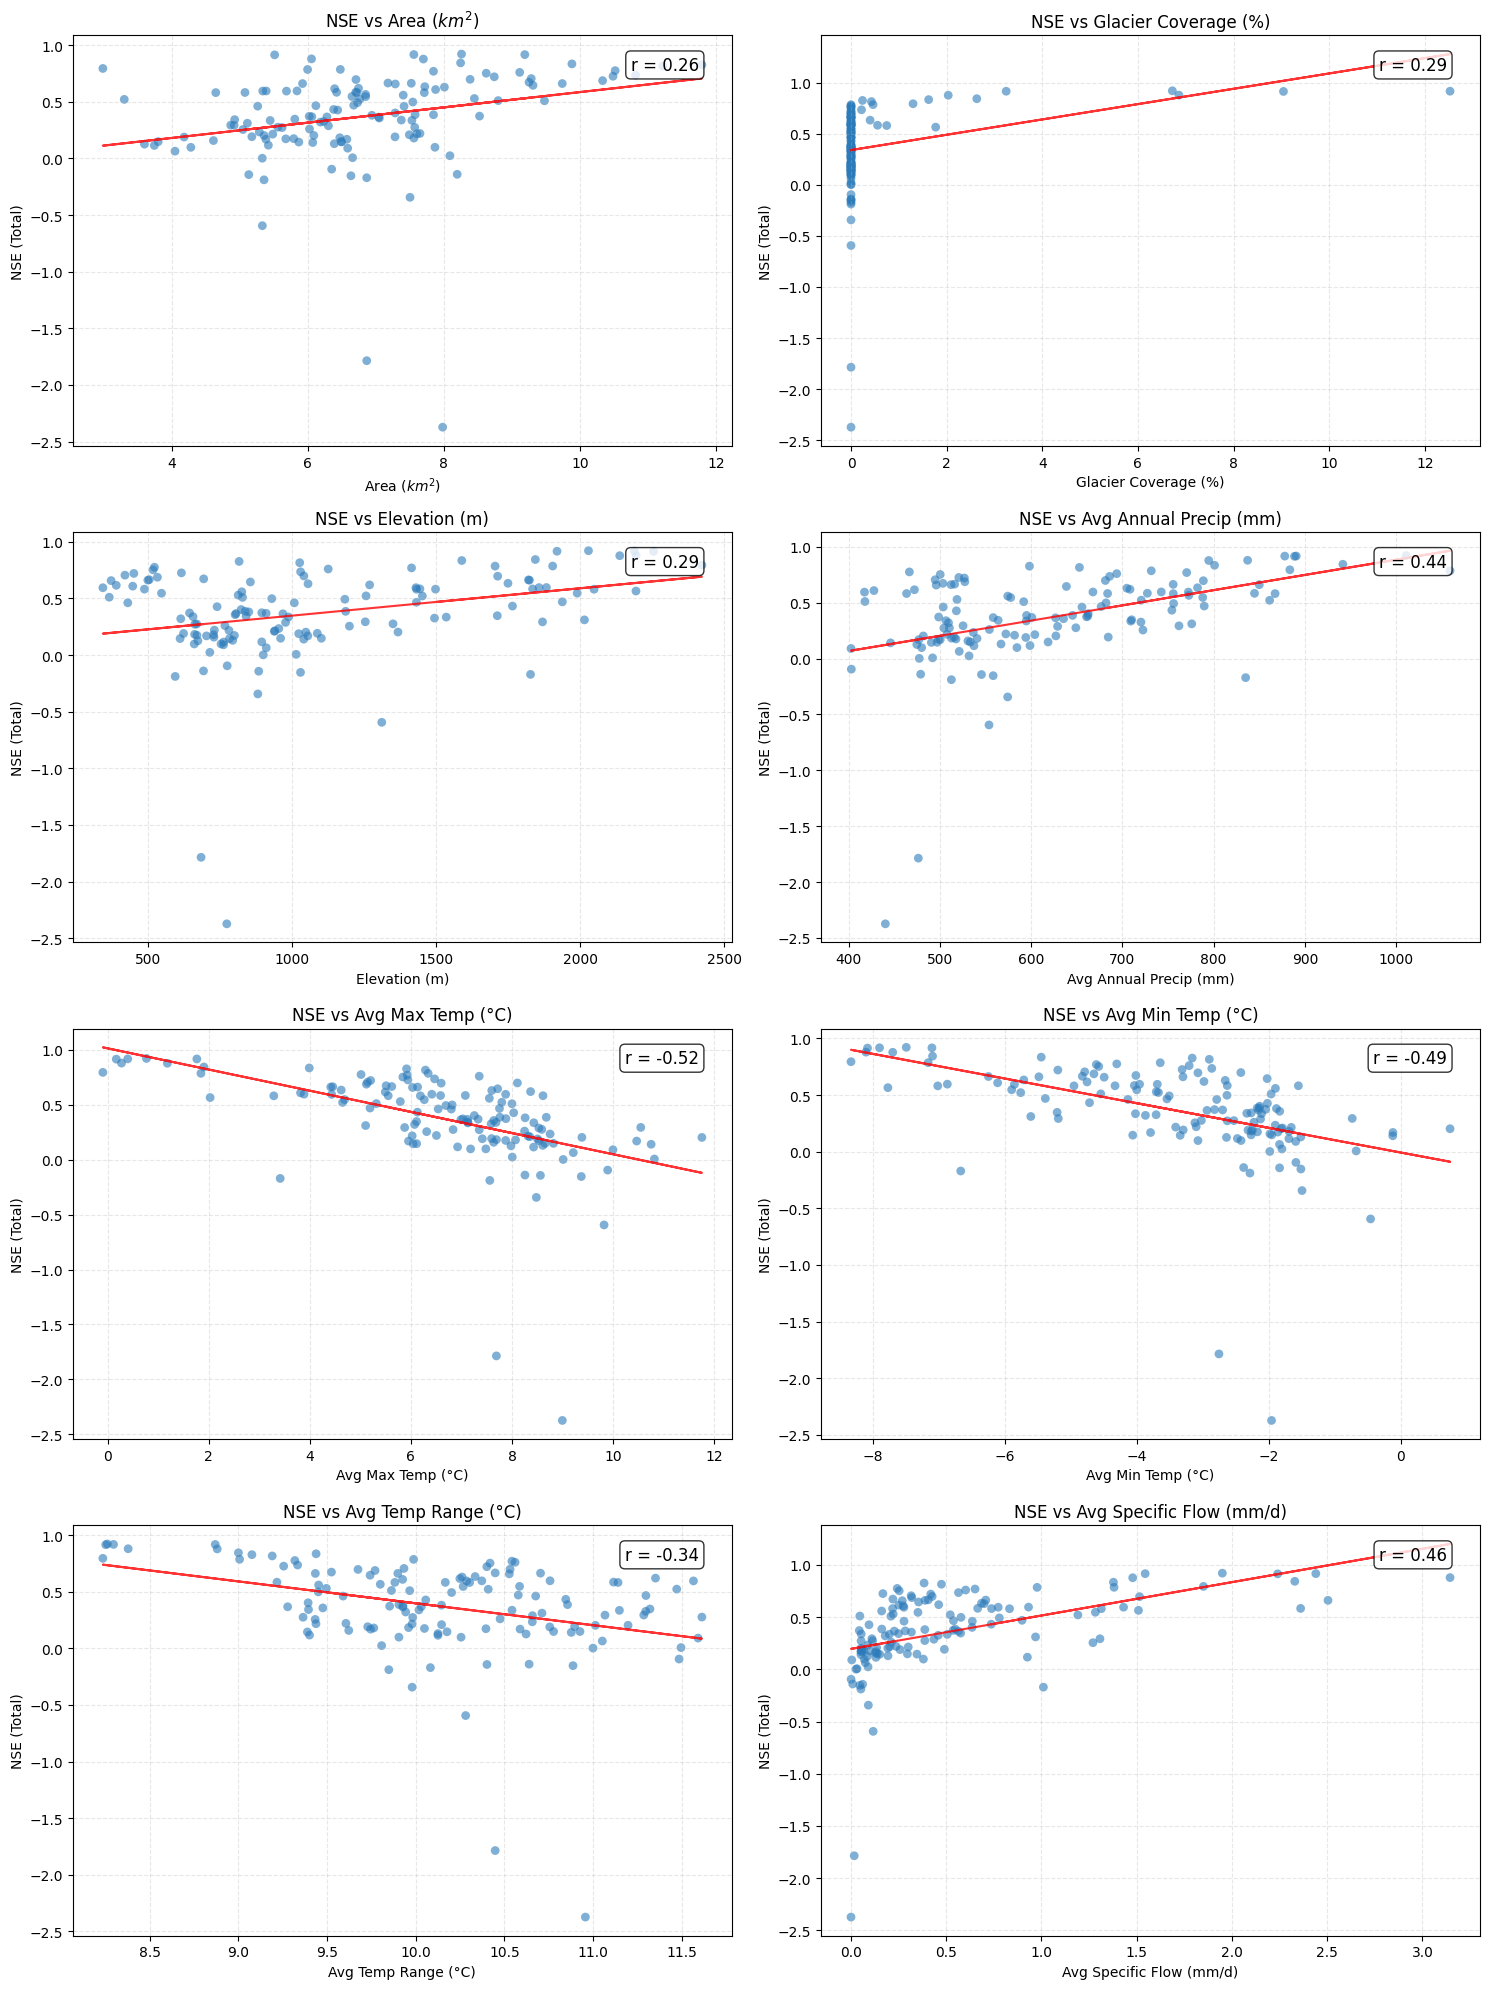

In [19]:
# --- 4. Generate Scatter Plots ---
attributes = [
    "Area ($km^2$)", "Glacier Coverage (%)", "Elevation (m)",
    "Avg Annual Precip (mm)", "Avg Max Temp (°C)", "Avg Min Temp (°C)",
    "Avg Temp Range (°C)", "Avg Specific Flow (mm/d)"
]

fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, attr in enumerate(attributes):
    ax = axes[i]
    
    # Drop NaNs for this specific pair
    subset = df_plot[[attr, "NSE"]].dropna()
    x = subset[attr]
    y = subset["NSE"]
    
    # 1. Scatter Plot
    ax.scatter(x, y, alpha=0.6, c="#2b7bba", edgecolors='none', s=40)
    
    # 2. Trendline (Linear Regression)
    if len(x) > 1:
        # polyfit returns [slope, intercept]
        m, b = np.polyfit(x, y, 1)
        ax.plot(x, m*x + b, color="red", linewidth=1.5, alpha=0.8)
        
        # Calculate Correlation (r)
        corr = np.corrcoef(x, y)[0, 1]
        
        # Add text box
        ax.text(0.95, 0.95, f"r = {corr:.2f}", transform=ax.transAxes, 
                fontsize=12, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle="round", fc="white", alpha=0.8))

    ax.set_title(f"NSE vs {attr}", fontsize=12)
    ax.set_xlabel(attr)
    ax.set_ylabel("NSE (Total)")
    ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()